In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [2]:
df = pd.read_pickle('../results/results.pkl')

In [3]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

In [9]:
def get_loss(
    args_dict,
):
    run_df = get_rows(args_dict)

    rank_set = np.unique(run_df['rank'])
    seed_set = np.unique(run_df['seed'])
    test_loss, test_loss_mean, test_loss_std = {}, {}, {}
    
    for method in ['sgd', 'ours']:
        test_loss_mean[method], test_loss_std[method], test_loss[method] = {}, {}, {}
        group_df = run_df[run_df['method'] == method].reset_index(drop=True)        
        for rank in rank_set:
            rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
            test_loss[method][rank], test_loss_mean[method][rank], test_loss_std[method][rank] = {}, {}, {}
            for seed in seed_set:
                seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)        
                if method == 'sgd':
                    min_loss_index = seed_df['val_loss'].idxmin()
                    row_with_min_loss = seed_df.loc[min_loss_index]
                    test_loss[method][rank][seed] = row_with_min_loss['test_loss']

                elif method == 'ours':
                    test_loss[method][rank][seed] = seed_df['test_loss'].iloc[0]
                else:
                    raise notImplementError(f"We only support sgd and ours, not {method}!")
        
            test_loss_mean[method][rank] = pd.Series(test_loss[method][rank]).median()
            test_loss_std[method][rank] = pd.Series(test_loss[method][rank]).std()
    return pd.DataFrame(test_loss_mean), pd.DataFrame(test_loss_std)

In [16]:
# loading the data

random_linear = get_loss({
    'activation': 'linear',
    'use_bias': 0,
    'target_depth': 1,
    'frozen_depth': 2,
    'init_mode': 'default',
    'width': 16,
    'exp': 'fnn',
    'pretrained': 0,
    'rank_step': 0,
})

random_fnn = get_loss({
    'activation': 'relu',
    'use_bias': 1,
    'target_depth': 2,
    'frozen_depth': 4,
    'init_mode': 'default',
    'width': 16,
    'exp': 'fnn',
    'pretrained': 0,
    'tune_bias': 1,
    'rank_step': 0,
})

pretrained_linear = get_loss({
    'activation': 'linear',
    'use_bias': 0,
    'target_depth': 1,
    'frozen_depth': 2,
    'init_mode': 'default',
    'width': 16,
    'exp': 'fnn',
    'pretrained': 1,
    'rank_step': 0,
})

pretrained_fnn = get_loss({
    'activation': 'relu',
    'use_bias': 1,
    'target_depth': 2,
    'frozen_depth': 4,
    'init_mode': 'default',
    'width': 16,
    'exp': 'fnn',
    'pretrained': 1,
    'tune_bias': 1,
    'rank_step': 0,
})

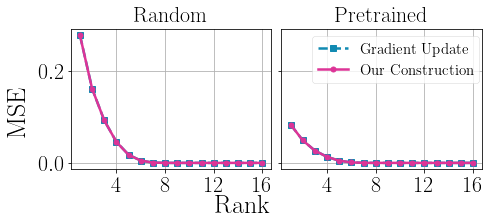

In [17]:
# Figure 1 setup
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

rank_set = list(random_fnn[0].index)
sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
fig.subplots_adjust(left=0.15, bottom=.23, right=0.99, top=0.88, wspace=0.05, hspace=0.05)
fig.set_size_inches(6.8, 3)

random_linear[0]['sgd'].plot(ax=ax[0], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
random_linear[0]['ours'].plot(ax=ax[0], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

pretrained_linear[0]['sgd'].plot(ax=ax[1], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
pretrained_linear[0]['ours'].plot(ax=ax[1], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

# ax[0].fill_between(rank_set, random_linear[0]['sgd'] - random_linear[1]['sgd'], random_linear[0]['sgd'] + random_linear[1]['sgd'], color=sgd_color, alpha=0.5)
# ax[0].fill_between(rank_set, random_linear[0]['ours'] - random_linear[1]['ours'], random_linear[0]['ours'] + random_linear[1]['ours'], color=our_color, alpha=0.5)
# ax[1].fill_between(rank_set, pretrained_linear[0]['sgd'] - pretrained_linear[1]['sgd'], pretrained_linear[0]['sgd'] + pretrained_linear[1]['sgd'], color=sgd_color, alpha=0.5)
# ax[1].fill_between(rank_set, pretrained_linear[0]['ours'] - pretrained_linear[1]['ours'], pretrained_linear[0]['ours'] + pretrained_linear[1]['ours'], color=our_color, alpha=0.5)

# set the x-ticks

for i in range(2):
    ax[i].set_xticks([4, 8, 12, 16])
    ax[i].grid(True)

ax[1].legend(fontsize=15, bbox_to_anchor=(1.02,1))
ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)


plt.savefig('../figures/figure1.pdf')
plt.show()

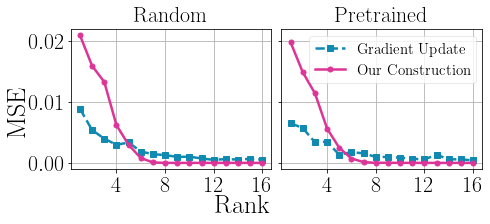

In [14]:
# Figure 2 setup
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
fig.subplots_adjust(left=0.15, bottom=.23, right=0.99, top=0.88, wspace=0.05, hspace=0.05)
fig.set_size_inches(6.8, 3)

random_fnn[0]['sgd'].plot(ax=ax[0], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
random_fnn[0]['ours'].plot(ax=ax[0], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

pretrained_fnn[0]['sgd'].plot(ax=ax[1], color=sgd_color, label='Gradient Update', linestyle=sgd_lt, marker=sgd_marker, linewidth=lw, markersize=sgd_ms)
pretrained_fnn[0]['ours'].plot(ax=ax[1], color=our_color, label='Our Construction', linestyle=our_lt, marker=our_marker, linewidth=lw, markersize=our_ms)

# ax[0].fill_between(rank_set, random_fnn[0]['sgd'] - random_fnn[1]['sgd'], random_fnn[0]['sgd'] + random_fnn[1]['sgd'], color=sgd_color, alpha=0.5)
# ax[0].fill_between(rank_set, random_fnn[0]['ours'] - random_fnn[1]['ours'], random_fnn[0]['ours'] + random_fnn[1]['ours'], color=our_color, alpha=0.5)
# ax[1].fill_between(rank_set, pretrained_fnn[0]['sgd'] - pretrained_fnn[1]['sgd'], pretrained_fnn[0]['sgd'] + pretrained_fnn[1]['sgd'], color=sgd_color, alpha=0.5)
# ax[1].fill_between(rank_set, pretrained_fnn[0]['ours'] - pretrained_fnn[1]['ours'], pretrained_fnn[0]['ours'] + pretrained_fnn[1]['ours'], color=our_color, alpha=0.5)

# set the x-ticks

for i in range(2):
    ax[i].set_xticks([4, 8, 12, 16])
    ax[i].grid(True)

ax[1].legend(fontsize=15, bbox_to_anchor=(0.1,1))
ax[0].set_title('Random', size = 22, y = 1.01)
ax[1].set_title('Pretrained', size = 22, y = 1.01)

fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)


plt.savefig('../figures/figure2.pdf')
plt.show()